May 2022

Si Fig. 4.

Analyzing a full-rank network trained to perform the DMS task through low-rank networks fitted to it.

Trained with dms_fullrank_fit.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from low_rank_rnns import dms, stats, plotting as plot, helpers, ranktwo, clustering
from low_rank_rnns.modules import *

In [2]:
plot.setup_matplotlib()
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26
plt.rcParams['legend.fontsize'] = 22

In [3]:
size = 1024
noise_std = 5e-2
alpha = .2
x_train, y_train, mask_train, x_val, y_val, mask_val = dms.generate_dms_data(1000)
net = FullRankRNN(2, size, 1, noise_std, alpha)
net.load_state_dict(torch.load(f'../models/dms_fr_{size}_0.1_1e-05.pt', map_location='cpu'))
loss, acc = dms.test_dms(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.066, acc=1.000


In [4]:
# We see that the rank-1 network does not work
net_tmp = LowRankRNN(2, size, size, noise_std, alpha, rank=1)
net_tmp.load_state_dict(torch.load(f'../models/dms_matched_r1.pt', map_location='cpu'))
net2 = LowRankRNN(2, size, 1, noise_std, alpha, rank=1, wi_init=net_tmp.wi_full, m_init=net_tmp.m, n_init=net_tmp.n, 
                  wo_init=net.wo_full * size)
loss, acc = dms.test_dms(net2, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.662, acc=0.730


In [5]:
# But the rank-2 is perfect!
net_tmp = LowRankRNN(2, size, size, noise_std, alpha, rank=2)
net_tmp.load_state_dict(torch.load(f'../models/dms_matched_r2.pt', map_location='cpu'))
net2 = LowRankRNN(2, size, 1, noise_std, alpha, rank=2, wi_init=net_tmp.wi_full, m_init=net_tmp.m, n_init=net_tmp.n, 
                  wo_init=net.wo_full * size)
loss, acc = dms.test_dms(net2, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.074, acc=1.000


0.9412217989155591
0.9041531150131823


/Users/avalente/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


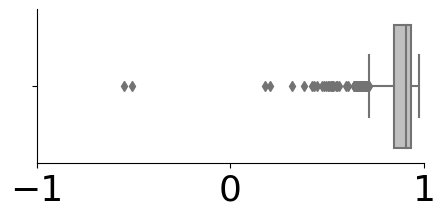

In [6]:
fig, ax = plt.subplots(figsize=(5, 2))
outp, traj = net.forward(x_val, return_dynamics=True)
outp2, traj2 = net2.forward(x_val, return_dynamics=True)

traj = traj.detach().numpy()
traj2 = traj2.detach().numpy()
r2_global = stats.r2_score(np.tanh(traj).ravel(), np.tanh(traj2).ravel())
print(r2_global)
r2s = stats.r2_idneurons(traj, traj2, return_all=True)
print(np.median(r2s))
sns.boxplot(r2s, orient='horizontal', color='silver', ax=ax)
plt.xlim(-1, 1)
plt.savefig('../figures/neurips/dms_boxplot.pdf', bbox_inches='tight')

In [7]:
(r2s < -1).sum()

0

In [9]:
net2.svd_reparametrization()

In [10]:
wi1 = net2.wi[0].detach().numpy()
wi2 = net2.wi[1].detach().numpy()
n1 = net2.n[:, 0].detach().numpy()
n2 = net2.n[:, 1].detach().numpy()
m1 = net2.m[:, 0].detach().numpy()
m2 = net2.m[:, 1].detach().numpy()
wo = net2.wo.detach().squeeze().numpy()

In [11]:
x, _, _, epochs = dms.generate_ordered_inputs()

In [12]:
_, traj = net.forward(x, return_dynamics=True)
_, traj2 = net2.forward(x, return_dynamics=True)

traj = traj.detach().numpy()
traj2 = traj2.detach().numpy()

In [13]:
kap1 = traj @ m1 / size
kap2 = traj @ m2 / size
kap1_2 = traj2 @ m1 / size
kap2_2 = traj2 @ m2 / size

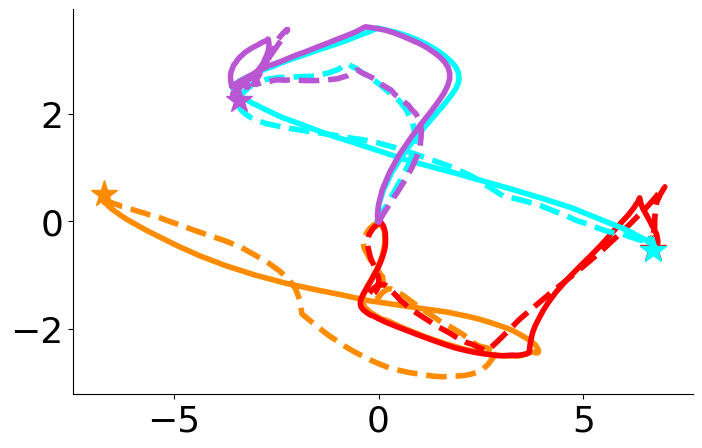

In [14]:
plt.subplots(figsize=(8,5))
colors = ['darkorange', 'red', 'cyan', 'mediumorchid']
labels = ['A-A', 'A-B', 'B-A', 'B-B']
for i in range(4):
    plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, label=labels[i])
    plt.plot(kap1_2[i], kap2_2[i], c=colors[i], lw=4, ls='--')
    plt.plot(kap1[i, -1], kap2[i, -1], c=colors[i], marker='*', markersize=20)
# plt.legend(bbox_to_anchor=(1,.85))
plt.savefig('../figures/neurips/dms_kappas.pdf', bbox_inches='tight')

In [15]:
traj.shape

(4, 131, 1024)

(524, 1024)


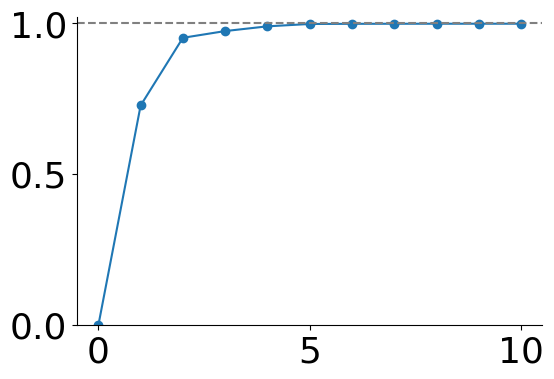

In [16]:
pca = plot.pca_cumvar(traj, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
# plt.xlabel('PC component')
# plt.ylabel('cum. exp. var. ratio')
plt.savefig('../figures/neurips/dms_pca.pdf', bbox_inches='tight')

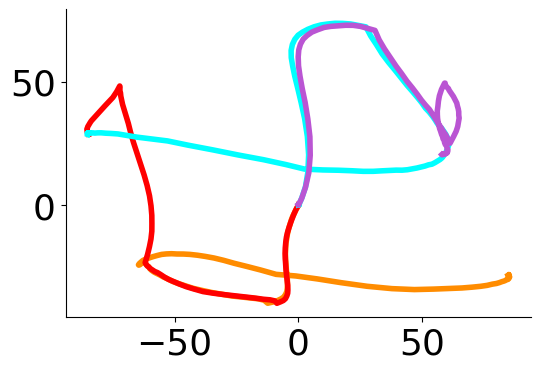

In [17]:
ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = traj @ ax1
k2 = traj @ ax2
k3 = traj @ ax3

for i in range(4):
    plt.plot(k1[i], k2[i], c=colors[i], lw=4, label=labels[i])

In [18]:
traj.shape

(4, 131, 1024)

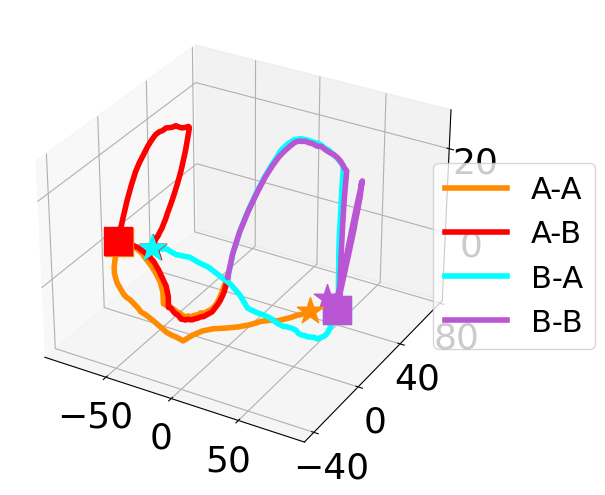

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
colors = ['darkorange', 'red', 'cyan', 'mediumorchid']

for i in range(4):
    plt.plot(k1[i], k2[i], k3[i], c=colors[i], lw=4, label=labels[i])
    ax.scatter(k1[i, epochs[2]], k2[i, epochs[2]], k3[i, epochs[2]], c=colors[i],
            marker='s', s=400)
    ax.scatter(k1[i, -1], k2[i, -1], k3[i, -1], c=colors[i],
            marker='*', s=400)

# ax.view_init(elev=38, azim=90)
ax.set_yticks([-40, 0, 40, 80])
plt.legend(bbox_to_anchor=(1.3,.7))
plt.savefig('../figures/neurips/dms_pca_proj.pdf', bbox_inches='tight')

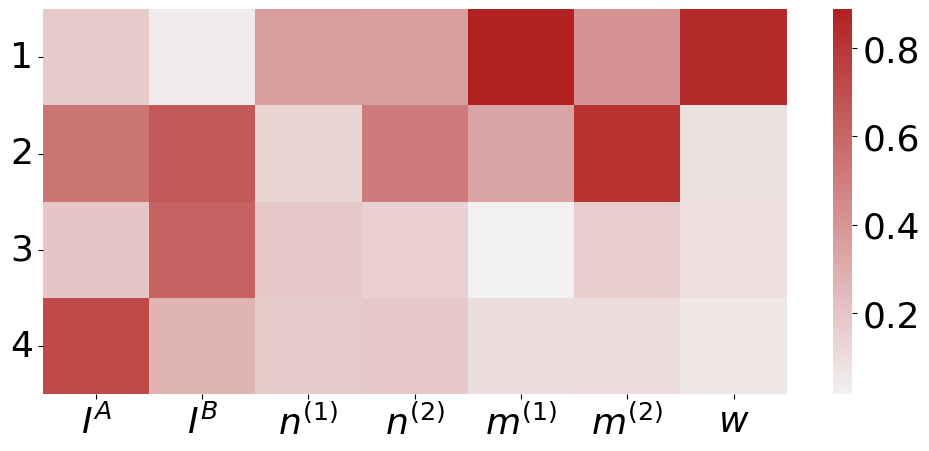

In [20]:
vecs_pca = [ax1, ax2, ax3, ax4]
vecs_fit = [wi1, wi2, n1, n2, m1, m2, wo]

helpers.overlap_matrix2(vecs_pca, vecs_fit, norm='l2', figsize=(12, 5), abs=True, cmap='abs')
# plt.xlabel('Fitted connectivity')
# plt.ylabel('TDR axes')
plt.xticks(np.arange(0.5, 7, 1), ['$I^A$', '$I^B$', '$n^{(1)}$', '$n^{(2)}$', '$m^{(1)}$', '$m^{(2)}$', '$w$'])
plt.yticks(np.arange(0.5, 4, 1), ['1', '2', '3', '4'], rotation='horizontal')
plt.savefig('../figures/neurips/dms_pcalint.pdf', bbox_inches='tight')
plt.show()

# Fields

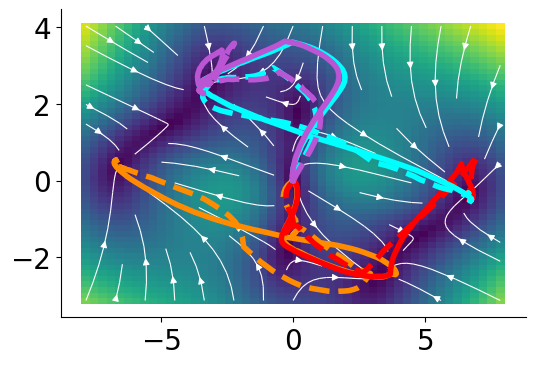

In [21]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net2, m1, m2, -8, 8, -3.2, 4.1)
for i in range(4):
    plt.plot(kap1[i], kap2[i], c=colors[i], lw=4)
    plt.plot(kap1_2[i], kap2_2[i], c=colors[i], lw=4, ls='--')
plt.savefig('../figures/neurips/dms_field_kappa.pdf', bbox_inches='tight')

In [22]:
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 26

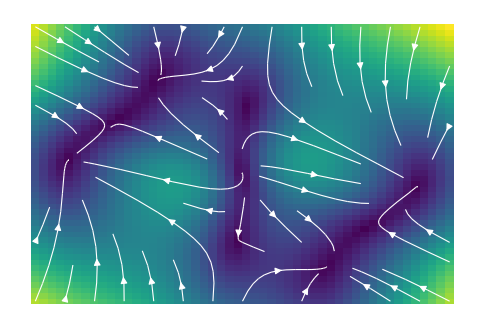

In [23]:
ranktwo.plot_field(net2, m1, m2, -8, 8, -3.5, 4)
plt.gca().set_axis_off()
plt.savefig('../figures/neurips/dms_field1.pdf', bbox_inches='tight')

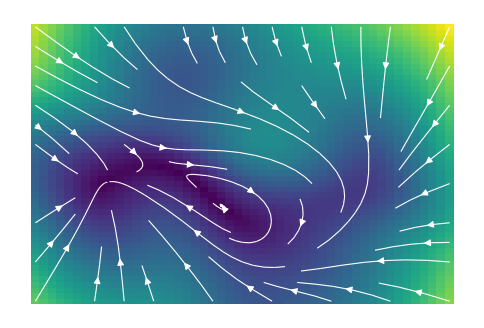

In [24]:
ranktwo.plot_field(net2, m1, m2, -8, 8, -3.5, 4, input=torch.tensor([1.,0]))
plt.gca().set_axis_off()
plt.savefig('../figures/neurips/dms_field2.pdf', bbox_inches='tight')

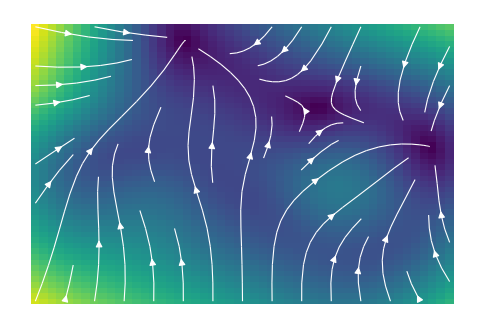

In [25]:
ranktwo.plot_field(net2, m1, m2, -8, 8, -3.5, 4, input=torch.tensor([0.,1]))
plt.gca().set_axis_off()
plt.savefig('../figures/neurips/dms_field3.pdf', bbox_inches='tight')

# Detailed trajectories

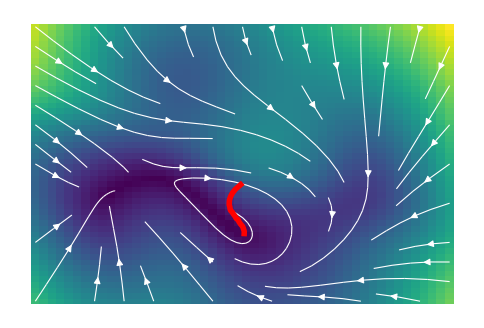

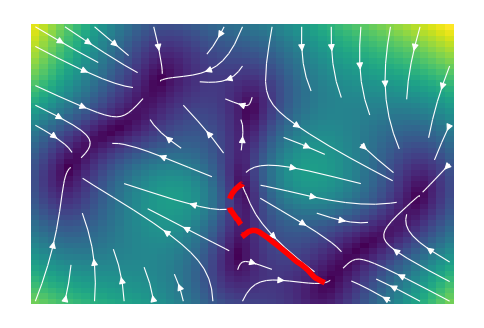

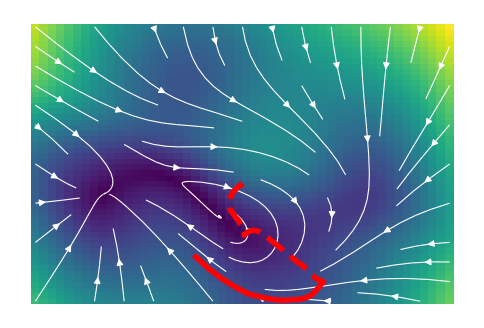

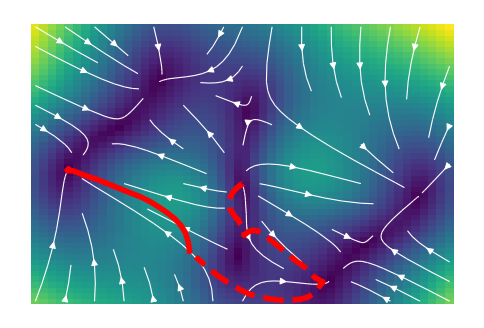

In [26]:
dms.plot_trial_epochs(net2, x[0].reshape((1, -1, 2)), epochs, rect=[-8,8,-3,4])

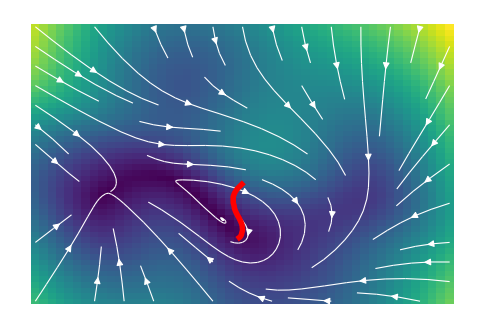

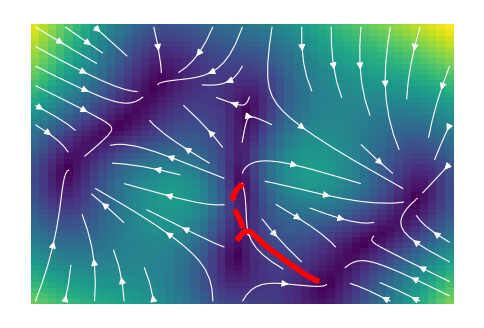

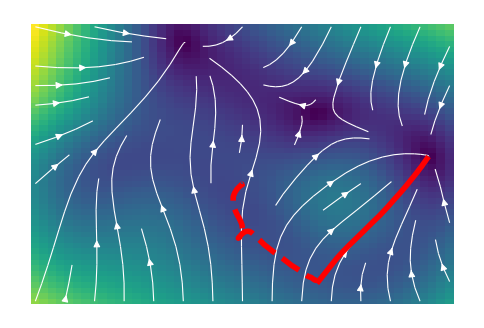

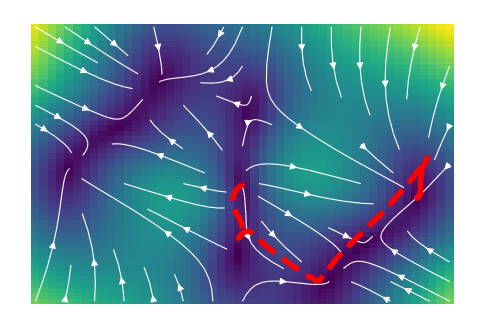

In [27]:
dms.plot_trial_epochs(net2, x[1].reshape((1, -1, 2)), epochs, rect=[-8,8,-3,4])

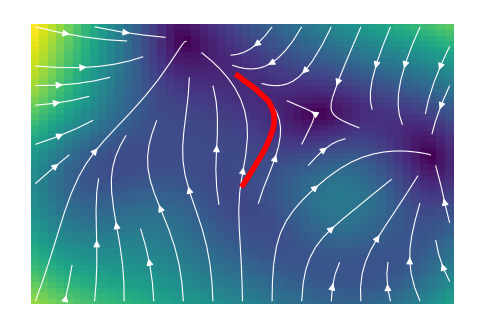

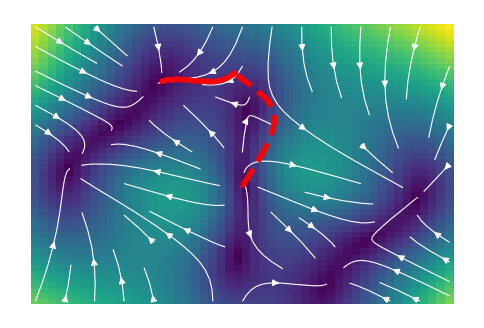

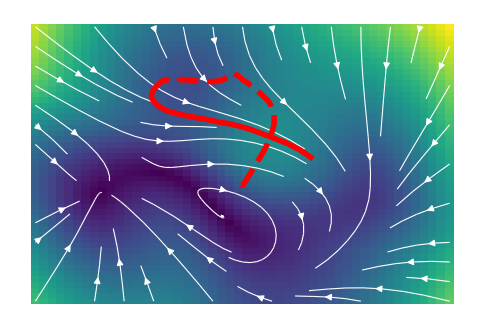

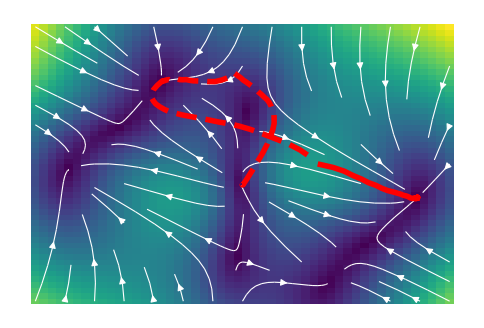

In [28]:
dms.plot_trial_epochs(net2, x[2].reshape((1, -1, 2)), epochs, rect=[-8,8,-3,4])

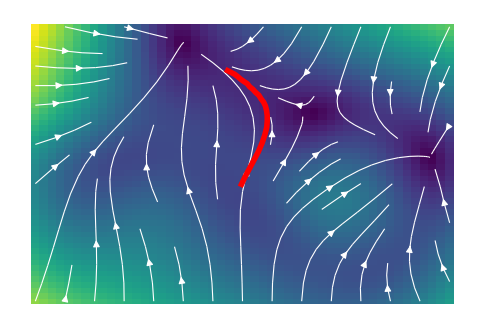

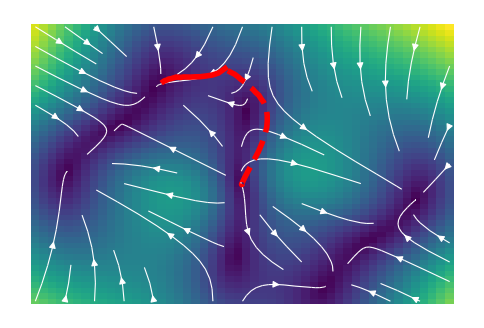

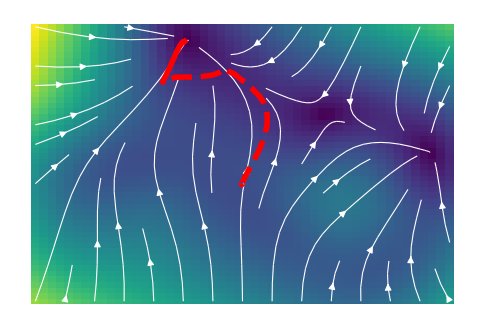

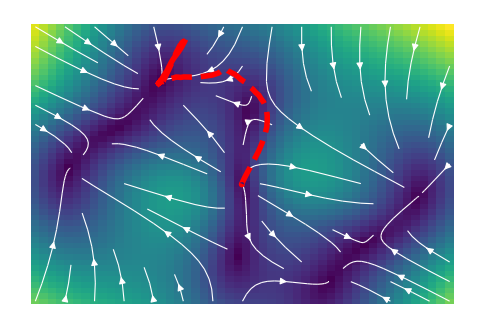

In [29]:
dms.plot_trial_epochs(net2, x[3].reshape((1, -1, 2)), epochs, rect=[-8,8,-3,4])

# Connectivity

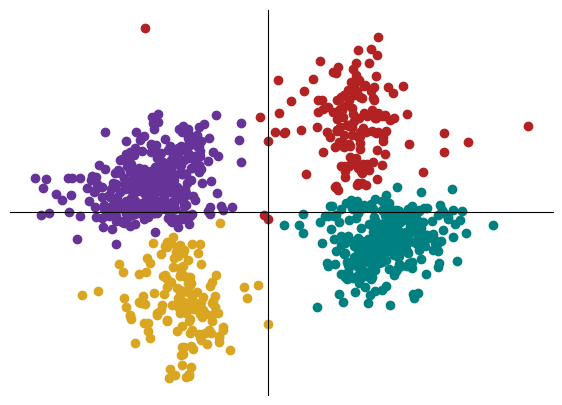

In [30]:
z, _ = clustering.gmm_fit([m1, m2], 4)
colors = ['rebeccapurple', 'teal', 'goldenrod', 'firebrick']
fig, ax = plt.subplots(figsize=(7,5))
for i in range(4):
    ax.scatter(m1[z==i], m2[z==i], c=colors[i])
plot.center_axes(ax)
plt.savefig('../figures/neurips/dms_m1m2.pdf', bbox_inches='tight')

pop 0: slope=0.46, intercept=-0.05
pop 1: slope=-0.23, intercept=-0.04


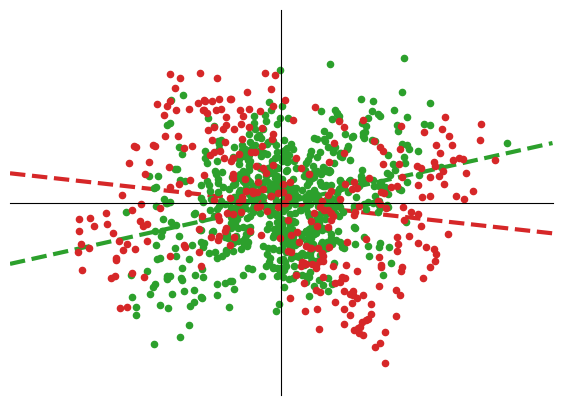

In [32]:
fig, ax = plt.subplots(figsize=(7,5))
z2 = np.where(np.abs(wi1) > 1, 1, 0)
clustering.pop_scatter_linreg(m2, n1, z2, colors=['tab:green', 'tab:red'], dotsize=20, ls='--', lw=3, ax=ax)
plt.savefig('../figures/neurips/dms_m2n1_1.pdf', bbox_inches='tight')

pop 0: slope=-0.31, intercept=-0.11
pop 1: slope=0.39, intercept=0.01


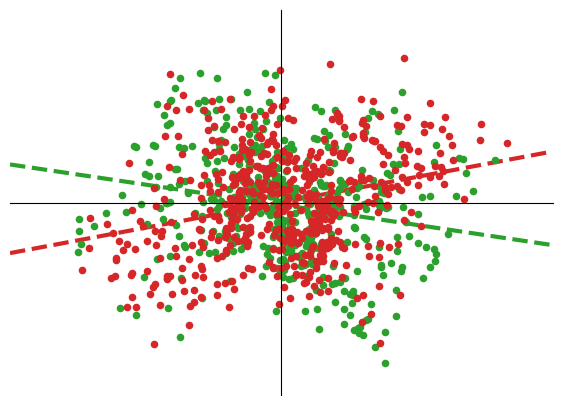

In [33]:
fig, ax = plt.subplots(figsize=(7,5))
z2 = np.where(np.abs(wi2) > 1, 1, 0)
clustering.pop_scatter_linreg(m2, n1, z2, colors=['tab:green', 'tab:red'], dotsize=20, ls='--', lw=3, ax=ax)
plt.savefig('../figures/neurips/dms_m2n1_2.pdf', bbox_inches='tight')

In [34]:
print(np.unique(z2, return_counts=True))

(array([0, 1]), array([478, 546]))


In [35]:
n1_eff1 = n1 * helpers.phi_prime(wi1)
n2_eff1 = n2 * helpers.phi_prime(wi1)
n1_eff2 = n1 * helpers.phi_prime(wi2)
n2_eff2 = n2 * helpers.phi_prime(wi2)

In [36]:
jac = np.array([[m1 @ n1, m1 @ n2],
                [m2 @ n1, m2 @ n2]]) / size
jac1 = np.array([[m1 @ n1_eff1, m1 @ n2_eff1],
                 [m2 @ n1_eff1, m2 @ n2_eff1]]) / size
jac2 = np.array([[m1 @ n1_eff2, m1 @ n2_eff2],
                 [m2 @ n1_eff2, m2 @ n2_eff2]]) / size
print(jac)
print(jac1)
print(jac2)

[[ 2.6718316  -0.55146015]
 [ 0.2153028   1.7502654 ]]
[[ 1.6039124  -0.5658767 ]
 [ 0.46892333  0.7443417 ]]
[[ 1.1365442  -0.20274237]
 [-0.29988825  0.7970341 ]]
